In [277]:
import pandas as pd
import numpy as np

from itertools import combinations, product
import matplotlib
from matplotlib import pyplot as plt
# plt.rcParams['figure.figsize']=(20,10)
# plt.style.use('ggplot')
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense,LSTM, Dropout, Bidirectional, Conv2D, MaxPooling2D

In [278]:
deaths_df = pd.read_csv('../combined_data.csv', index_col=0)
# deaths_df = df.drop(['new_confirmed_cases'], axis=1).iloc[35:]
deaths_df.head()

,Date,no2,ozone,pm25,County,new_deaths
0,2020-01-26,0.015,0.034,7.3,Alameda,0.0
1,2020-01-27,0.024,0.032,9.9,Alameda,0.0
2,2020-01-28,0.025,0.033,9.7,Alameda,0.0
3,2020-01-29,0.022,0.024,11.8,Alameda,0.0
4,2020-01-30,0.022,0.021,10.2,Alameda,0.0


In [279]:
def nth_day_feature(df, feature, n):
    rows = df.shape[0]
    nth_prior_measurement = [None]*n + [df[feature][i-n] for i in range(n, rows)]
    col_name = f'{feature}_{n}'
    df[col_name] = nth_prior_measurement

In [280]:
for feature in deaths_df.columns:
    if 'Date' in feature:
        continue
    if 'County' in feature:
        continue
    for n in range(1,21):
        nth_day_feature(deaths_df, feature, n)

In [281]:
deaths_df.head()

,Date,no2,ozone,pm25,County,new_deaths,no2_1,no2_2,no2_3,no2_4,...,new_deaths_11,new_deaths_12,new_deaths_13,new_deaths_14,new_deaths_15,new_deaths_16,new_deaths_17,new_deaths_18,new_deaths_19,new_deaths_20
0,2020-01-26,0.015,0.034,7.3,Alameda,0.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-01-27,0.024,0.032,9.9,Alameda,0.0,0.015,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-01-28,0.025,0.033,9.7,Alameda,0.0,0.024,0.015,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-01-29,0.022,0.024,11.8,Alameda,0.0,0.025,0.024,0.015,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-01-30,0.022,0.021,10.2,Alameda,0.0,0.022,0.025,0.024,0.015,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [282]:
to_remove = ['no2', 'pm25', 'ozone', 'County']
to_keep = [col for col in deaths_df.columns if col not in to_remove]
df = deaths_df[to_keep]
df.columns

Index(['Date', 'new_deaths', 'no2_1', 'no2_2', 'no2_3', 'no2_4', 'no2_5',
       'no2_6', 'no2_7', 'no2_8', 'no2_9', 'no2_10', 'no2_11', 'no2_12',
       'no2_13', 'no2_14', 'no2_15', 'no2_16', 'no2_17', 'no2_18', 'no2_19',
       'no2_20', 'ozone_1', 'ozone_2', 'ozone_3', 'ozone_4', 'ozone_5',
       'ozone_6', 'ozone_7', 'ozone_8', 'ozone_9', 'ozone_10', 'ozone_11',
       'ozone_12', 'ozone_13', 'ozone_14', 'ozone_15', 'ozone_16', 'ozone_17',
       'ozone_18', 'ozone_19', 'ozone_20', 'pm25_1', 'pm25_2', 'pm25_3',
       'pm25_4', 'pm25_5', 'pm25_6', 'pm25_7', 'pm25_8', 'pm25_9', 'pm25_10',
       'pm25_11', 'pm25_12', 'pm25_13', 'pm25_14', 'pm25_15', 'pm25_16',
       'pm25_17', 'pm25_18', 'pm25_19', 'pm25_20', 'new_deaths_1',
       'new_deaths_2', 'new_deaths_3', 'new_deaths_4', 'new_deaths_5',
       'new_deaths_6', 'new_deaths_7', 'new_deaths_8', 'new_deaths_9',
       'new_deaths_10', 'new_deaths_11', 'new_deaths_12', 'new_deaths_13',
       'new_deaths_14', 'new_deaths_15', '

In [283]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10144 entries, 0 to 10143
Data columns (total 82 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Date           10144 non-null  object 
 1   new_deaths     10144 non-null  float64
 2   no2_1          10143 non-null  float64
 3   no2_2          10142 non-null  float64
 4   no2_3          10141 non-null  float64
 5   no2_4          10140 non-null  float64
 6   no2_5          10139 non-null  float64
 7   no2_6          10138 non-null  float64
 8   no2_7          10137 non-null  float64
 9   no2_8          10136 non-null  float64
 10  no2_9          10135 non-null  float64
 11  no2_10         10134 non-null  float64
 12  no2_11         10133 non-null  float64
 13  no2_12         10132 non-null  float64
 14  no2_13         10131 non-null  float64
 15  no2_14         10130 non-null  float64
 16  no2_15         10129 non-null  float64
 17  no2_16         10128 non-null  float64
 18  no2_17

In [284]:
spread = df.describe().T

IQR = spread['75%'] - spread['25%']
spread['outliers'] = (spread['min']<(spread['25%']-(3*IQR)))|(spread['max'] > (spread['75%']+3*IQR))
spread.loc[spread.outliers]

,count,mean,std,min,25%,50%,75%,max,outliers
new_deaths,10144.0,1.943513,6.388663,-1.0,0.000,0.000,1.000,91.00,True
no2_1,10143.0,0.009788,0.008464,0.0,0.004,0.007,0.013,0.06,True
no2_2,10142.0,0.009788,0.008465,0.0,0.004,0.007,0.013,0.06,True
no2_3,10141.0,0.009789,0.008465,0.0,0.004,0.007,0.013,0.06,True
no2_4,10140.0,0.009789,0.008465,0.0,0.004,0.007,0.013,0.06,True
...,...,...,...,...,...,...,...,...,...
new_deaths_16,10128.0,1.945596,6.393324,-1.0,0.000,0.000,1.000,91.00,True
new_deaths_17,10127.0,1.945788,6.393611,-1.0,0.000,0.000,1.000,91.00,True
new_deaths_18,10126.0,1.945783,6.393926,-1.0,0.000,0.000,1.000,91.00,True
new_deaths_19,10125.0,1.945877,6.394235,-1.0,0.000,0.000,1.000,91.00,True


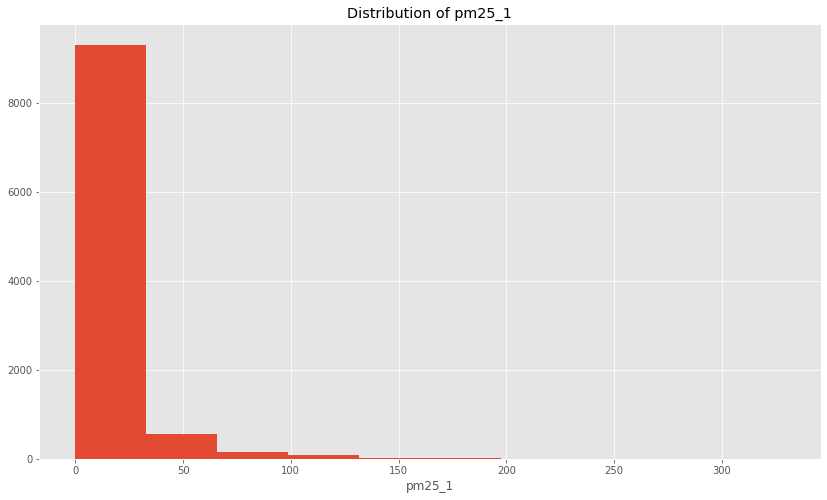

In [285]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 8]
df.pm25_1.hist()
plt.title('Distribution of pm25_1')
plt.xlabel('pm25_1')
plt.show()

In [286]:
df = df.dropna()
df

,Date,new_deaths,no2_1,no2_2,no2_3,no2_4,no2_5,no2_6,no2_7,no2_8,...,new_deaths_11,new_deaths_12,new_deaths_13,new_deaths_14,new_deaths_15,new_deaths_16,new_deaths_17,new_deaths_18,new_deaths_19,new_deaths_20
20,2020-02-15,0.0,0.018,0.018,0.028,0.033,0.027,0.005,0.015,0.024,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,2020-02-16,0.0,0.020,0.018,0.018,0.028,0.033,0.027,0.005,0.015,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,2020-02-17,0.0,0.014,0.020,0.018,0.018,0.028,0.033,0.027,0.005,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,2020-02-18,0.0,0.022,0.014,0.020,0.018,0.018,0.028,0.033,0.027,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,2020-02-19,0.0,0.032,0.022,0.014,0.020,0.018,0.018,0.028,0.033,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10139,2020-12-03,0.0,0.012,0.008,0.008,0.010,0.006,0.006,0.001,0.004,...,0.0,0.0,2.0,1.0,1.0,0.0,2.0,2.0,0.0,2.0
10140,2020-12-04,0.0,0.010,0.012,0.008,0.008,0.010,0.006,0.006,0.001,...,0.0,0.0,0.0,2.0,1.0,1.0,0.0,2.0,2.0,0.0
10141,2020-12-05,3.0,0.010,0.010,0.012,0.008,0.008,0.010,0.006,0.006,...,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,2.0,2.0
10142,2020-12-06,0.0,0.004,0.010,0.010,0.012,0.008,0.008,0.010,0.006,...,0.0,0.0,0.0,0.0,0.0,2.0,1.0,1.0,0.0,2.0


In [287]:
df_corr = df.corr()[['new_deaths']].sort_values('new_deaths')
df_corr.T

,pm25_16,pm25_15,pm25_20,pm25_19,pm25_14,pm25_17,pm25_18,pm25_13,pm25_8,pm25_7,...,new_deaths_20,new_deaths_4,new_deaths_15,new_deaths_13,new_deaths_8,new_deaths_6,new_deaths_1,new_deaths_14,new_deaths_7,new_deaths
new_deaths,0.043812,0.044593,0.04783,0.047974,0.050227,0.050478,0.052326,0.057587,0.059817,0.06101,...,0.630447,0.639732,0.66457,0.669537,0.687896,0.696014,0.715956,0.76244,0.786176,1.0


In [288]:
predictors = list(df_corr[df_corr['new_deaths'].abs() > 0.44].T.columns)
predictors.remove('new_deaths')
df_clean = df[['new_deaths'] + predictors]
df_clean

,new_deaths,new_deaths_19,new_deaths_17,new_deaths_18,new_deaths_16,new_deaths_12,new_deaths_11,new_deaths_10,new_deaths_9,new_deaths_5,...,new_deaths_2,new_deaths_20,new_deaths_4,new_deaths_15,new_deaths_13,new_deaths_8,new_deaths_6,new_deaths_1,new_deaths_14,new_deaths_7
20,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
23,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10139,0.0,0.0,2.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,2.0,1.0,1.0,2.0,0.0,1.0,4.0,1.0,0.0
10140,0.0,2.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,1.0,...,4.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,1.0
10141,3.0,2.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,2.0,0.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0
10142,0.0,0.0,1.0,1.0,2.0,0.0,0.0,0.0,1.0,0.0,...,0.0,2.0,4.0,0.0,0.0,0.0,1.0,3.0,0.0,1.0


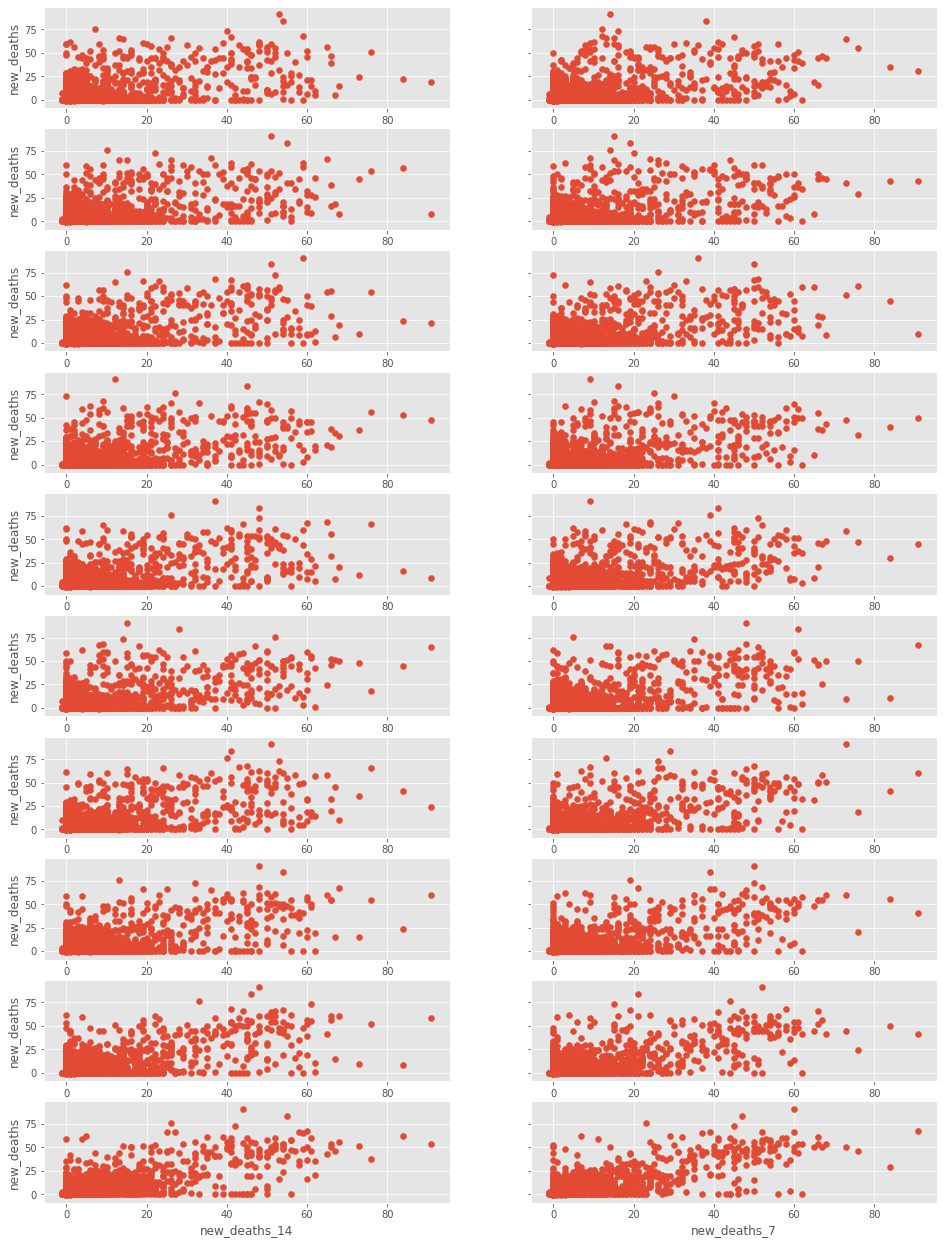

In [289]:
plt.rcParams['figure.figsize'] = [16,22]
fig, axes = plt.subplots(nrows=10, ncols=2, sharey=True)
arr = np.array(predictors).reshape(10, 2)

for row, col_arr in enumerate(arr):
    for col, feature in enumerate(col_arr):
        axes[row, col].scatter(df_clean[feature], df_clean['new_deaths'])
        if col == 0:
            axes[row, col].set(xlabel=feature, ylabel='new_deaths')
        else:
            axes[row, col].set(xlabel=feature)
            
plt.show()

In [290]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

In [291]:
X = df_clean[predictors]
y = df_clean['new_deaths']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=12)

In [292]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [293]:
regressor = LinearRegression()
regressor.fit(X_train_scaled, y_train)
prediction = regressor.predict(X_test_scaled)

In [294]:
from sklearn.metrics import mean_absolute_error, median_absolute_error
print("The Explained Variance: %.2f" % regressor.score(X_test_scaled, y_test))
print("The Mean Absolute Error: %.2f deaths" % mean_absolute_error(y_test, prediction))
print("The Median Absolute Error: %.2f deaths" % median_absolute_error(y_test, prediction))

The Explained Variance: 0.74
The Mean Absolute Error: 1.52 deaths
The Median Absolute Error: 0.47 deaths


In [295]:
X = df[[col for col in df.columns if col != 'new_deaths' and 'Date' not in col]]
y = df['new_deaths']
X.columns

Index(['no2_1', 'no2_2', 'no2_3', 'no2_4', 'no2_5', 'no2_6', 'no2_7', 'no2_8',
       'no2_9', 'no2_10', 'no2_11', 'no2_12', 'no2_13', 'no2_14', 'no2_15',
       'no2_16', 'no2_17', 'no2_18', 'no2_19', 'no2_20', 'ozone_1', 'ozone_2',
       'ozone_3', 'ozone_4', 'ozone_5', 'ozone_6', 'ozone_7', 'ozone_8',
       'ozone_9', 'ozone_10', 'ozone_11', 'ozone_12', 'ozone_13', 'ozone_14',
       'ozone_15', 'ozone_16', 'ozone_17', 'ozone_18', 'ozone_19', 'ozone_20',
       'pm25_1', 'pm25_2', 'pm25_3', 'pm25_4', 'pm25_5', 'pm25_6', 'pm25_7',
       'pm25_8', 'pm25_9', 'pm25_10', 'pm25_11', 'pm25_12', 'pm25_13',
       'pm25_14', 'pm25_15', 'pm25_16', 'pm25_17', 'pm25_18', 'pm25_19',
       'pm25_20', 'new_deaths_1', 'new_deaths_2', 'new_deaths_3',
       'new_deaths_4', 'new_deaths_5', 'new_deaths_6', 'new_deaths_7',
       'new_deaths_8', 'new_deaths_9', 'new_deaths_10', 'new_deaths_11',
       'new_deaths_12', 'new_deaths_13', 'new_deaths_14', 'new_deaths_15',
       'new_deaths_16', 'new_d

In [296]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_x.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1,1))

In [297]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=23)

In [298]:
model = Sequential()
model.add(Dense(100, input_dim=X_train.shape[1], activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(50, activation='relu'))
model.add(Dense(10, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
model.summary()

Model: "sequential_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_74 (Dense)             (None, 100)               8100      
_________________________________________________________________
dropout_20 (Dropout)         (None, 100)               0         
_________________________________________________________________
dense_75 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_76 (Dense)             (None, 10)                510       
_________________________________________________________________
dropout_21 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_77 (Dense)             (None, 1)                 11        
Total params: 13,671
Trainable params: 13,671
Non-trainable params: 0
_________________________________________________

In [300]:
history = model.fit(X_train, y_train, epochs=100, verbose=1, validation_split=0.2)

Train on 6479 samples, validate on 1620 samples
Epoch 1/100
6479/6479 [==============================] - 1s 125us/sample - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 2/100
6479/6479 [==============================] - 1s 118us/sample - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0019 - val_mse: 0.0019
Epoch 3/100
6479/6479 [==============================] - 1s 118us/sample - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 4/100
6479/6479 [==============================] - 1s 119us/sample - loss: 0.0018 - mse: 0.0018 - val_loss: 0.0021 - val_mse: 0.0021
Epoch 5/100
6479/6479 [==============================] - 1s 120us/sample - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 6/100
6479/6479 [==============================] - 1s 121us/sample - loss: 0.0017 - mse: 0.0017 - val_loss: 0.0018 - val_mse: 0.0018
Epoch 7/100
6479/6479 [==============================] - 1s 122us/sample - loss: 0.0018 - mse: 0.0018 - val_loss: 0.00

6479/6479 [==============================] - 1s 125us/sample - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 60/100
6479/6479 [==============================] - 1s 126us/sample - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0016 - val_mse: 0.0016
Epoch 61/100
6479/6479 [==============================] - 1s 129us/sample - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 62/100
6479/6479 [==============================] - 1s 130us/sample - loss: 0.0014 - mse: 0.0014 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 63/100
6479/6479 [==============================] - 1s 129us/sample - loss: 0.0015 - mse: 0.0015 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 64/100
6479/6479 [==============================] - 1s 129us/sample - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0015 - val_mse: 0.0015
Epoch 65/100
6479/6479 [==============================] - 1s 128us/sample - loss: 0.0013 - mse: 0.0013 - val_loss: 0.0017 - val_mse: 0.0017
Epoch 66/100
6479/6479 [=========

dict_keys(['loss', 'mse', 'val_loss', 'val_mse'])


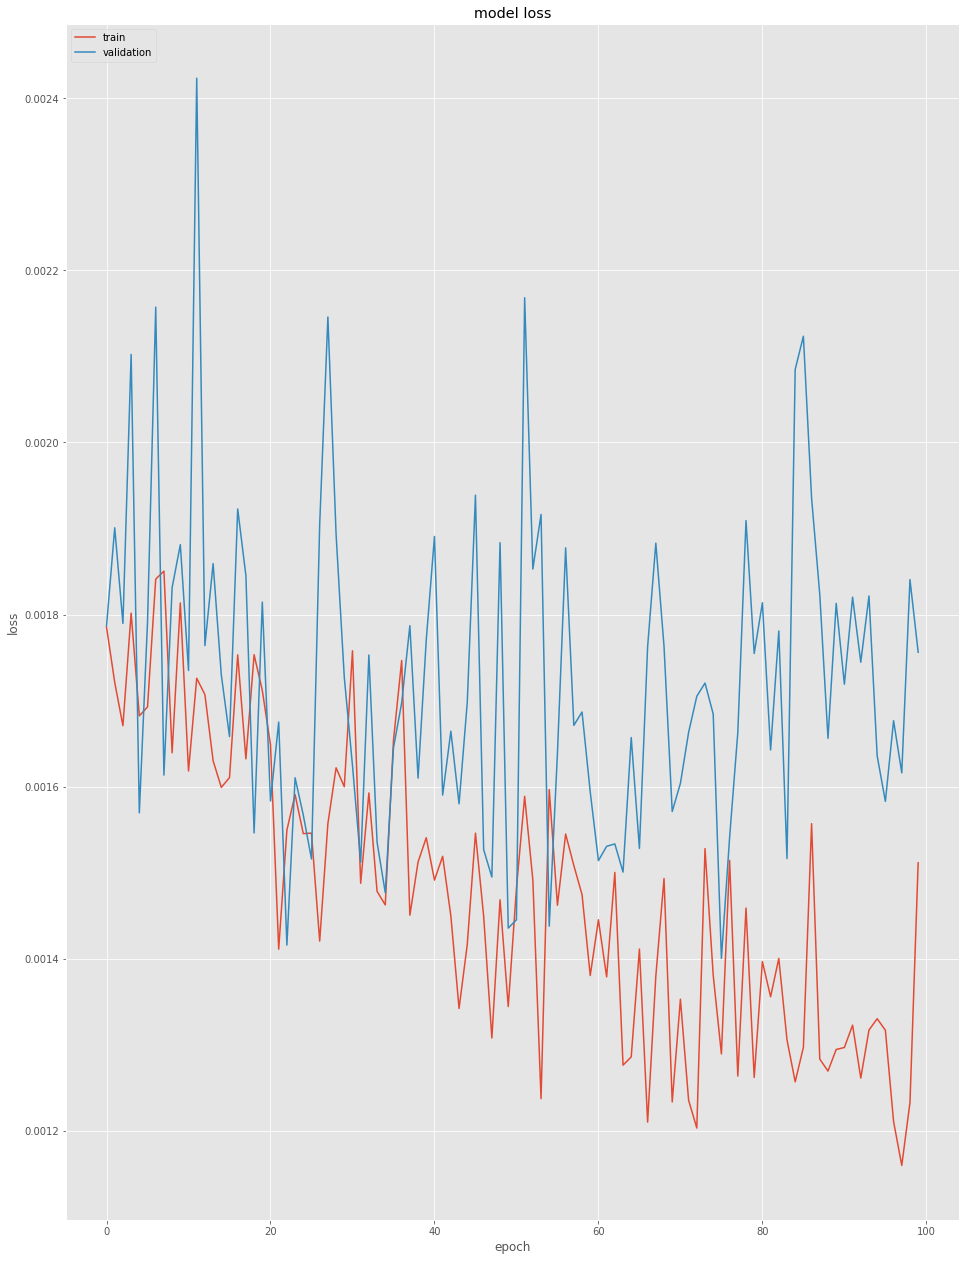

In [301]:
print(history.history.keys())
# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [302]:
predictions = model.predict(X_test)
invert_predictions = scaler_y.inverse_transform(predictions)
invert_y_test = scaler_y.inverse_transform(y_test)
print("The Mean Absolute Error: %.2f deaths" % mean_absolute_error(invert_y_test, invert_predictions))

The Mean Absolute Error: 1.60 deaths
